In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import csv
import math
import random
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Image Prep

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import csv
import math
import random
import os # Import os module
from google.colab import drive

drive.mount('/content/drive')

# Custom Salt and Pepper Noise transform
class SaltAndPepperNoise(object):
    def __init__(self, amount):
        self.amount = amount

    def __call__(self, img):
        img_np = np.array(img)
        row, col, ch = img_np.shape
        num_salt = np.ceil(self.amount * img_np.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img_np.shape]
        img_np[coords[0], coords[1], :] = 255

        num_pepper = np.ceil(self.amount * img_np.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img_np.shape]
        img_np[coords[0], coords[1], :] = 0
        return transforms.ToPILImage()(img_np)

# Custom Occlusion transform
class Occlusion(object):
    def __init__(self, area_ratio):
        self.area_ratio = area_ratio

    def __call__(self, img):
        img_np = np.array(img)
        h, w, _ = img_np.shape
        mask_size = int(np.sqrt(self.area_ratio * h * w))
        x = np.random.randint(0, w - mask_size)
        y = np.random.randint(0, h - mask_size)
        img_np[y:y + mask_size, x:x + mask_size, :] = 0  # Black occlusion
        return transforms.ToPILImage()(img_np)

class CelebA(torch.utils.data.Dataset):
    def __init__(self, split):
        self.dir = '/content/drive/MyDrive/CVPR_Dataset'  # Update with your actual dataset path
        self.all_files = []
        self.labels = {}
        classes = ["Healthy", "Early Blight", "Late Blight", "Leaf Mold", "Septoria"]

        for i, disease in enumerate(classes):
            disease_path = os.path.join(self.dir, disease) # Use os.path.join for path
            # Check if the directory exists before listing files
            if os.path.isdir(disease_path):
                files = glob(os.path.join(disease_path, '*.jpg')) # Use os.path.join and glob
                for file in files:
                    self.all_files.append(file)
                    self.labels[file] = i # Assign integer label using full file path as key
            else:
                print(f"Warning: Directory not found: {disease_path}") # Warn if directory not found


        random.shuffle(self.all_files) # Shuffle all files to ensure random splits

        # Define splits based on the total number of images
        total_images = len(self.all_files)
        if total_images == 0:
            print(f"Error: No images found in the directory: {self.dir}")
            self.files = []
        else:
            train_end = int(0.8 * total_images) # 80% for training
            valid_end = int(0.9 * total_images) # 10% for validation
            test_end = int(1.0 * total_images) # 10% for testing

            if split == 'train':
                self.files = self.all_files[:train_end]
            elif split == 'valid':
                self.files = self.all_files[train_end:valid_end]
            elif split == 'test':
                self.files = self.all_files[valid_end:test_end]
            elif split == 'test_ref':
                 # Assuming test_ref is the same as test for now, adjust if needed
                self.files = self.all_files[valid_end:test_end]
            else:
                raise ValueError(f"Invalid split: {split}")


        self.length = len(self.files)

        img_size = 128
        if split == 'train':
            self.transform = transforms.Compose([
                transforms.ToPILImage(), # Convert to PIL Image for some transforms
                transforms.RandomRotation(degrees=(-15, 15)),
                SaltAndPepperNoise(amount=0.15),
                transforms.GaussianBlur(kernel_size=3), # Changed radius to kernel_size
                Occlusion(area_ratio=0.15),
                transforms.ToTensor(), # Convert back to Tensor
                transforms.RandomApply([transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.07)], p=1.0), # Gaussian Noise
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.01),
                transforms.Resize([img_size, img_size]),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
            # Multi-item Data Augmentation is applied by applying multiple transforms sequentially
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([img_size, img_size]),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])

    def __getitem__(self, index):
        filename = self.files[index]
        img = cv2.imread(filename)
        # Check if image was loaded successfully
        if img is None:
            print(f"Warning: Could not load image {filename}. Skipping.")
            # Return a dummy or None, or handle this based on how DataLoader handles None
            # For now, returning None might cause issues with the DataLoader's default collate_fn
            # A better approach might be to filter out unreadable files during initialization
            return None, None # Or raise an error, depending on desired behavior


        label = self.labels[filename]


        if self.transform:
            img = self.transform(img)

        return img, torch.LongTensor([label])

    def sample(self, n):
        if n > len(self.all_files): n = len(self.all_files)
        self.files = random.sample(self.all_files, n)
        self.length = n

    def __len__(self):
        return self.length


# Restore images to suitable images of opencv style
def ImgForPlot(img):
    img = np.einsum('ijk->jki', img)
    img = (127.5*(img+1)).astype(np.uint8)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Define batch_size and workers here
batch_size = 8
workers = 2

dataset = CelebA('train')
ref_dataset = CelebA('train')
ref2_dataset = CelebA('train')

test_dataset = CelebA('test')
test_ref_dataset = CelebA('test_ref')

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
ref_dataloader = DataLoader(ref_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
ref2_dataloader = DataLoader(ref2_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=workers)
ref_test_dataloader = DataLoader(test_ref_dataset, batch_size=16, shuffle=False, num_workers=workers)

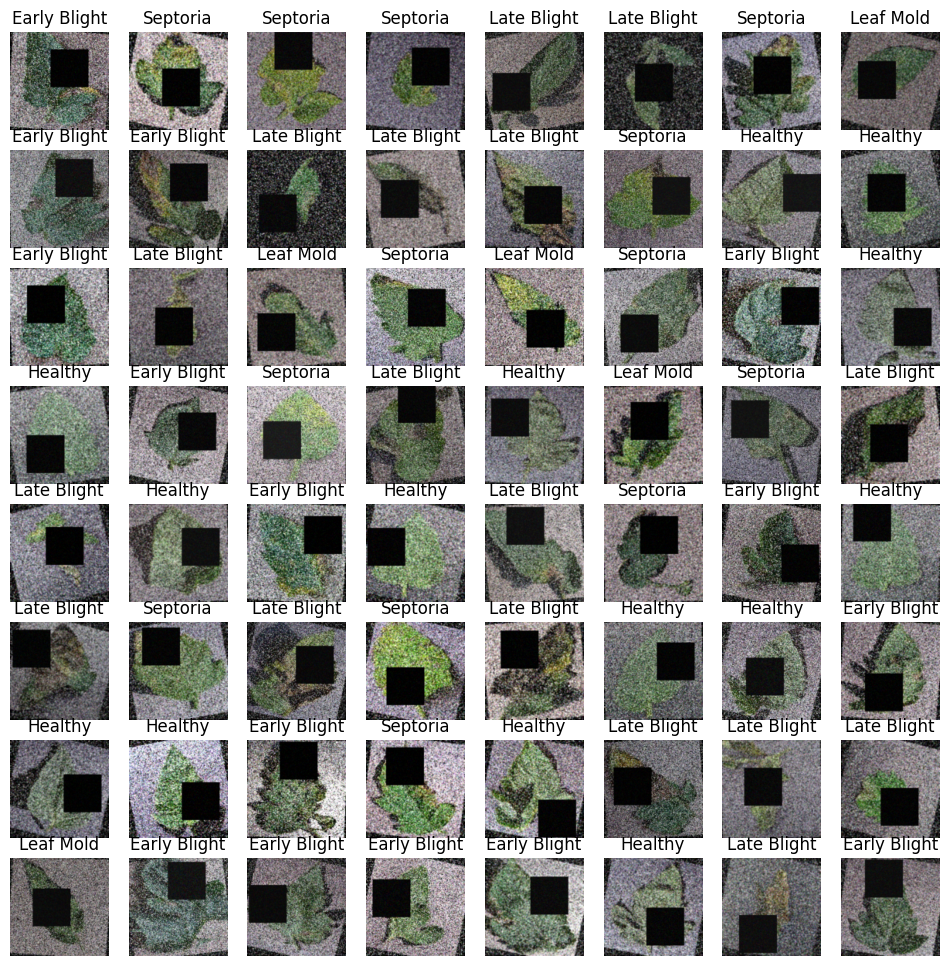

In [ ]:
fig = plt.figure(figsize=(12,12))

# Update classes to match the tomato disease labels
classes = ["Healthy", "Early Blight", "Late Blight", "Leaf Mold", "Septoria"]
for k in range(64):
    img, label = dataset[k]
    ax = fig.add_subplot(8, 8, k+1)
    ax.imshow(ImgForPlot(img))
    ax.axis("off")
    ax.set_title(classes[label])

plt.show()

Hyper Parameter

In [ ]:
nf = 64
nz = 64
nd = 5
sdim = 64

lambda_gp = 1.
lambda_sty = 1.
lambda_ds = 1.
lambda_cyc = 1.

lr = 1e-5
lr_f = 1e-6
betas = (0.0, 0.99)
weight_decay = 1e-4

batch_size = 8
epochs = 15
ds_epochs = 5
n_print = 100
n_img_save = 2000

workers = 2
isCuda = True
device = torch.device("cuda:0" if (torch.cuda.cuda() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True
print("Device: {}".format(device))

model_saved_dir = "."

AttributeError: module 'torch.cuda' has no attribute 'cuda'

Model

In [ ]:
def init_conv_weight(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.)

def init_fc_weight_zero(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.)

def init_fc_weight_one(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.constant_(m.bias, 1.)

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, norm=False, down=False):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, in_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)

        self.norm = norm
        if norm:
            self.norm1 = nn.InstanceNorm2d(in_ch, affine=True)
            self.norm2 = nn.InstanceNorm2d(in_ch, affine=True)

        self.lrelu = nn.LeakyReLU(0.2)
        self.is_down = down

        self.is_sc = in_ch != out_ch
        if self.is_sc:
            self.sc = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)

    def down(self, x):
        return F.avg_pool2d(x, 2)

    def forward(self, x):
        if self.norm: res = self.norm1(x)
        else: res = x
        res = self.conv1(self.lrelu(res))
        if self.is_sc: x = self.sc(x)
        if self.is_down:
            x = self.down(x)
            res = self.down(res)
        if self.norm: res = self.norm2(res)
        res = self.conv2(self.lrelu(res))
        return (x + res) / math.sqrt(2)

In [ ]:
class AdaIN(nn.Module):
    def __init__(self, sdim, nf):
        super(AdaIN, self).__init__()
        self.norm = nn.InstanceNorm2d(nf)
        self.gamma = nn.Linear(sdim, nf)
        self.beta = nn.Linear(sdim, nf)
        self.apply(init_fc_weight_one)

    def forward(self, x, s):
        B, C, H, W = x.size()
        return (1 + self.gamma(s).view(B, C, 1, 1)) * self.norm(x) + self.beta(s).view(B, C, 1, 1)

In [ ]:
class AdaINResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, sdim, up=False):
        super(AdaINResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
        self.norm1 = AdaIN(sdim, in_ch)
        self.norm2 = AdaIN(sdim, out_ch)
        self.lrelu = nn.LeakyReLU(0.2)
        self.is_up = up
        self.is_sc = in_ch != out_ch
        if self.is_sc:
            self.sc = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)

    def up(self, x):
        return F.interpolate(x, scale_factor=2, mode='nearest')

    def forward(self, x, s):
        res = self.lrelu(self.norm1(x, s))
        if self.is_up:
            x = self.up(x)
            res = self.up(res)
        if self.is_sc: x = self.sc(x)
        res = self.conv1(res)
        res = self.conv2(self.lrelu(self.norm2(res, s)))
        return (x + res) / math.sqrt(2)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nf, sdim):
        super(Generator, self).__init__()
        self.conv_in = nn.Conv2d(3, nf, 3, 1, 1)
        self.enc = nn.Sequential(
            ResBlock(nf, 2*nf, norm=True, down=True),
            ResBlock(2*nf, 4*nf, norm=True, down=True),
            ResBlock(4*nf, 8*nf, norm=True, down=True),
            ResBlock(8*nf, 8*nf, norm=True),
            ResBlock(8*nf, 8*nf, norm=True)
        )
        self.dec = nn.ModuleList([
            AdaINResBlock(8*nf, 8*nf, sdim),
            AdaINResBlock(8*nf, 8*nf, sdim),
            AdaINResBlock(8*nf, 4*nf, sdim, up=True),
            AdaINResBlock(4*nf, 2*nf, sdim, up=True),
            AdaINResBlock(2*nf, nf, sdim, up=True)
        ])
        self.conv_out = nn.Sequential(
            nn.InstanceNorm2d(nf, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(nf, 3, 1, 1, 0)
        )
        self.apply(init_conv_weight)

    def forward(self, x, s):
        x = self.conv_in(x)
        x = self.enc(x)
        for layer in self.dec:
            x = layer(x, s)
        x = self.conv_out(x)
        return x

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, nz, nd, sdim):
        super(MappingNetwork, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(nz, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )

        self.unshared = nn.ModuleList()
        for i in range(nd):
            self.unshared.append(nn.Sequential(
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, sdim)
            ))

        self.apply(init_conv_weight)
        self.apply(init_fc_weight_zero)

    def forward(self, z, y):          # z: B x nz, y: B
        B = z.size(0)
        z = self.shared(z)            # B x 512
        s = [layer(z) for layer in self.unshared]
        s = torch.stack(s, dim=1)     # B x nd x sdim
        i = torch.LongTensor(range(B)).cuda()
        return s[i, y]                # B x sdim

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nf, nd):
        super(Discriminator, self).__init__()
        self.conv_in = nn.Conv2d(3, nf, 3, 1, 1)
        self.res = nn.Sequential(
            ResBlock(nf, 2*nf, down=True),
            ResBlock(2*nf, 4*nf, down=True),
            ResBlock(4*nf, 8*nf, down=True),
            ResBlock(8*nf, 8*nf, down=True),
            ResBlock(8*nf, 8*nf, down=True)
        )
        self.conv_out = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(8*nf, 8*nf, 4, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8*nf, nd, 1, 1, 0)
        )
        self.apply(init_conv_weight)

    def forward(self, x, y):        # x: B x 3 x 128 x 128, y: B
        B = x.size(0)
        x = self.conv_in(x)         # B x nf x 128 x 128
        x = self.res(x)             # B x 8nf x 4 x 4
        x = self.conv_out(x)        # B x nd x 1 x 1
        x = x.view(B, -1)           # B x nd
        i = torch.LongTensor(range(B)).cuda()
        return x[i, y]              # B

In [ ]:
class StyleEncoder(nn.Module):
    def __init__(self, nf, nd, sdim):
        super(StyleEncoder, self).__init__()
        self.conv_in = nn.Conv2d(3, nf, 3, 1, 1)
        self.res = nn.Sequential(
            ResBlock(nf, 2*nf, down=True),
            ResBlock(2*nf, 4*nf, down=True),
            ResBlock(4*nf, 8*nf, down=True),
            ResBlock(8*nf, 8*nf, down=True),
            ResBlock(8*nf, 8*nf, down=True)
        )
        self.conv_out = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(8*nf, 8*nf, 4, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8*nf, nd*sdim, 1, 1, 0)
        )
        self.nd = nd
        self.apply(init_conv_weight)

    def forward(self, x, y):            # x: B x 3 x 128 x 128, y: B
        B = x.size(0)
        x = self.conv_in(x)             # B x nf x 128 x 128
        x = self.res(x)                 # B x 8nf x 4 x 4
        x = self.conv_out(x)            # B x nd*sdim x 1 x 1
        x = x.view(B, self.nd, -1)      # B x nd x sdim
        i = torch.LongTensor(range(B)).cuda()
        return x[i, y]                  # B x sdim

In [ ]:
class Model:
    def __init__(self, nf, nz, nd, sdim, lr, lr_f, betas, weight_decay):
        self.G = Generator(nf, sdim).cuda()
        self.F = MappingNetwork(nz, nd, sdim).cuda()
        self.D = Discriminator(nf, nd).cuda()
        self.E = StyleEncoder(nf, nd, sdim).cuda()

        self.optG = optim.Adam(self.G.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optF = optim.Adam(self.F.parameters(), lr=lr_f, betas=betas, weight_decay=weight_decay)
        self.optD = optim.Adam(self.D.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optE = optim.Adam(self.E.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

    def save(self, path):
        torch.save(self.G.state_dict(), path + '_G.pt')
        torch.save(self.F.state_dict(), path + '_F.pt')
        torch.save(self.D.state_dict(), path + '_D.pt')
        torch.save(self.E.state_dict(), path + '_E.pt')

    def load(self, path):
        self.G.load_state_dict(torch.load(path + '_G.pt'))
        self.F.load_state_dict(torch.load(path + '_F.pt'))
        self.D.load_state_dict(torch.load(path + '_D.pt'))
        self.E.load_state_dict(torch.load(path + '_E.pt'))

    def zero_grad(self):
        self.optG.zero_grad()
        self.optF.zero_grad()
        self.optD.zero_grad()
        self.optE.zero_grad()

    def train(self):
        self.G.train()
        self.F.train()
        self.D.train()
        self.E.train()

    def eval(self):
        self.G.eval()
        self.F.eval()
        self.D.eval()
        self.E.eval()

Train Model

In [ ]:
model = Model(nf, nz, nd, sdim, lr, lr_f, betas, weight_decay)

In [ ]:
def gradient_penalty(out, x):
    grad = torch.autograd.grad(
        outputs=out.sum(),
        inputs=x,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0].view(x.size(0), -1)
    return 0.5 * torch.mean(torch.sum(grad.pow(2), dim=1))

In [ ]:
import time

model_name = '_____'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
img_path = F"{model_saved_dir}/{model_name}_img.pkl"
model_path = F"{model_saved_dir}/{model_name}"

start_epoch = 0

# Initialize losses dictionary outside the if block
losses = {'train_d1': [], 'train_d2': [], 'train_g1': [], 'train_g2': []}

if start_epoch == 0:
    pass # losses is already initialized

l1 = nn.L1Loss()

lambda_ds_zero = lambda_ds
lambda_ds = max((lambda_ds_zero * (ds_epochs - start_epoch)) / epochs, 0.)

step, d1_sum, d2_sum, g1_sum, g2_sum = 0, 0., 0., 0., 0.
imgs = [] # Initialize the imgs list here
for ep in range(start_epoch, epochs):
    model.train()
    timestamp = time.time()
    for batch_idx, ((x, y), (x_ref, y_), (x_ref2, _)) in enumerate(zip(dataloader, ref_dataloader, ref2_dataloader)):
        step += 1
        x = x.cuda()
        x.requires_grad_()
        y = y.cuda().squeeze(1)
        x_ref = x_ref.cuda()
        y_ = y_.cuda().squeeze(1)
        x_ref2 = x_ref2.cuda()
        z = torch.randn((x.size(0), nz)).cuda()

        # Train Discriminator with z
        model.zero_grad()
        out = model.D(x, y)
        real_label = torch.full_like(out, fill_value=1).cuda() # Moved to GPU
        loss_real = F.binary_cross_entropy_with_logits(out, real_label)
        loss_gp = gradient_penalty(out, x)

        loss = loss_real + loss_fake + lambda_gp * loss_gp # Assuming fake_loss is defined later

        with torch.no_grad():
            s_ = model.F(z, y_)
            x_ = model.G(x, s_)
        out = model.D(x_, y_)

        fake_label = torch.full_like(out, fill_value=0).cuda() # Moved to GPU
        loss_fake = F.binary_cross_entropy_with_logits(out, fake_label)

        loss = loss_real + loss_fake + lambda_gp * loss_gp
        # Check for NaNs in loss before backward pass
        if torch.isnan(loss).any():
            print(f"NaN in D loss (z) at epoch {ep+1}, batch {batch_idx+1}")
            continue # Skip this batch if NaN is found

        loss.backward()
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.D.parameters(), max_norm=1.0)
        model.optD.step()

        losses['train_d1'].append(loss.item())
        d1_sum += loss.item()

        # Train Discriminator with x_ref
        model.zero_grad()
        out = model.D(x, y)
        real_label = torch.full_like(out, fill_value=1).cuda() # Moved to GPU
        loss_real = F.binary_cross_entropy_with_logits(out, real_label)
        loss_gp = gradient_penalty(out, x)

        with torch.no_grad():
            s_ = model.E(x_ref, y_)
            x_ = model.G(x, s_)

        out = model.D(x_, y_)
        fake_label = torch.full_like(out, fill_value=0).cuda() # Moved to GPU
        loss_fake = F.binary_cross_entropy_with_logits(out, fake_label)

        loss = loss_real + loss_fake + lambda_gp * loss_gp
        # Check for NaNs in loss before backward pass
        if torch.isnan(loss).any():
            print(f"NaN in D loss (x_ref) at epoch {ep+1}, batch {batch_idx+1}")
            continue # Skip this batch if NaN is found

        loss.backward()
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.D.parameters(), max_norm=1.0)
        model.optD.step()

        losses['train_d2'].append(loss.item())
        d2_sum += loss.item()

        # Train Generator with z, z2
        model.zero_grad()

        s_ = model.F(z, y_)
        x_ = model.G(x, s_)
        out = model.D(x_, y_)
        real_label = torch.full_like(out, fill_value=1).cuda() # Moved to GPU
        loss_adv = F.binary_cross_entropy_with_logits(out, real_label)

        s_pred = model.E(x_, y_)
        loss_sty = l1(s_, s_pred)

        z2 = torch.randn((x.size(0), nz)).cuda()
        s_2 = model.F(z2, y_)
        x_2 = model.G(x, s_2)
        loss_ds = l1(x_, x_2.detach())

        s = model.E(x, y)
        x_rec = model.G(x_, s)
        loss_cyc = l1(x, x_rec)

        loss = loss_adv + lambda_sty * loss_sty - lambda_ds * loss_ds + lambda_cyc * loss_cyc
        # Check for NaNs in loss before backward pass
        if torch.isnan(loss).any():
            print(f"NaN in G loss (z) at epoch {ep+1}, batch {batch_idx+1}")
            continue # Skip this batch if NaN is found

        loss.backward()
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.G.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(model.F.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(model.E.parameters(), max_norm=1.0)
        model.optG.step()
        model.optF.step()
        model.optE.step()

        losses['train_g1'].append(loss.item())
        g1_sum += loss.item()

        # Train Generator with x_ref, x_ref2
        model.zero_grad()

        s_ = model.E(x_ref, y_)
        x_ = model.G(x, s_)
        out = model.D(x_, y_)
        real_label = torch.full_like(out, fill_value=1).cuda() # Moved to GPU
        loss_adv = F.binary_cross_entropy_with_logits(out, real_label)

        s_pred = model.E(x_, y_)
        loss_sty = l1(s_, s_pred)

        s_2 = model.E(x_ref2, y_)
        x_2 = model.G(x, s_2)
        loss_ds = l1(x_, x_2.detach())

        s = model.E(x, y)
        x_rec = model.G(x_, s)
        loss_cyc = l1(x, x_rec)

        loss = loss_adv + lambda_sty * loss_sty - lambda_ds * loss_ds + lambda_cyc * loss_cyc
        # Check for NaNs in loss before backward pass
        if torch.isnan(loss).any():
            print(f"NaN in G loss (x_ref) at epoch {ep+1}, batch {batch_idx+1}")
            continue # Skip this batch if NaN is found

        loss.backward()
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.G.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(model.E.parameters(), max_norm=1.0)
        model.optG.step()
        losses['train_g2'].append(loss.item())
        g2_sum += loss.item()

        lambda_ds -= lambda_ds_zero / (len(dataloader) * epochs)
        lambda_ds = max(lambda_ds, 0.)

        if (batch_idx + ep * len(dataloader) + 1) % n_img_save == 0:
            model.eval()
            with torch.no_grad():
                temp_img = []
                for (x, _), (x_ref, y_) in zip(test_dataloader, ref_test_dataloader):
                    x = x.cuda()
                    x_ref = x_ref.cuda()
                    y_ = y_.cuda().squeeze(1)
                    s_ = model.E(x_ref, y_)
                    x_ = model.G(x, s_)
                    temp_img.append(x_)
                imgs.append(torch.cat(temp_img, dim=0))
            model.train()
            print("Iter %d: Generate images for test dataset" % (batch_idx + ep * len(dataloader) + 1))

        if (batch_idx + 1) % n_print == 0 or (batch_idx + 1) == len(dataloader):
            print('[%d/%d][%5d/%5d] Train (%ds)' % (ep+1, epochs, batch_idx+1, len(dataloader), time.time() - timestamp))
            print('\t[Loss] D1: %.4f / D2: %.4f / G1: %.4f / G2: %.4f' % (d1_sum/step, d2_sum/step, g1_sum/step, g2_sum/step))
            step, d1_sum, d2_sum, g1_sum, g2_sum = 0, 0., 0., 0., 0.
            timestamp = time.time()

    model.save(model_path)
    with open(loss_path, 'wb') as f:
        pickle.dump(losses, f)

    with open(img_path, 'wb') as f:
        pickle.dump(imgs, f)

    print("Saved model completely!")

In [ ]:
fig = plt.figure(figsize=(24,50))

# Check if imgs list is not empty
if not imgs:
    print("Error: No images saved in the 'imgs' list. Please ensure training completed and images were saved.")
else:
    img = imgs[-1]
    # Update classes to match the tomato disease labels
    classes = ["Healthy", "Early Blight", "Late Blight", "Leaf Mold", "Septoria"]

    # Determine the number of images to display based on the smaller test dataset
    num_display = min(len(test_dataset), len(test_ref_dataset))

    # Add a check to ensure datasets are not empty
    if num_display == 0:
        print("Error: Test datasets are empty. Cannot display images.")
    else:
        for k in range(num_display):
            x, y = test_dataset[k]
            x_ref, y_ref = test_ref_dataset[k]
            ax = fig.add_subplot(num_display, 3, 3*k+1) # Adjust subplot grid
            ax.imshow(ImgForPlot(x))
            ax.axis("off")
            ax.set_title('Source')
            ax = fig.add_subplot(num_display, 3, 3*k+2) # Adjust subplot grid

            # Add print statements to check pixel range
            print(f"Generated image {k}: Min value = {img[k].cpu().min()}, Max value = {img[k].cpu().max()}")

            ax.imshow(ImgForPlot(img[k].cpu()))
            ax.axis("off")
            ax.set_title('Generated') # Added title for generated image
            ax = fig.add_subplot(num_display, 3, 3*k+3) # Adjust subplot grid
            ax.imshow(ImgForPlot(x_ref))
            ax.axis("off")
            ax.set_title('Reference')

        plt.tight_layout() # Adjust layout to prevent titles overlapping
        plt.savefig('test.png')
        plt.show() # Show the plot

In [ ]:
t = [8, 11, 13, 15, 17, 18, 30, 35, 42, 46, 48, 51, 56, 58, 60, 71, 72, 74, 76, 78, 80, 87, 90, 92, 95]

fig = plt.figure(figsize=(24,50))

img = imgs[-1]
classes = ['Female', 'Male']

for i, k in enumerate(t):
    x, y = test_dataset[k]
    x_ref, y_ref = test_ref_dataset[k]
    ax = fig.add_subplot(13, 6, 3*i+1)
    ax.imshow(ImgForPlot(x))
    ax.axis("off")
    ax.set_title('Source')
    ax = fig.add_subplot(13, 6, 3*i+2)
    ax.imshow(ImgForPlot(img[k].cpu()))
    ax.axis("off")
    ax = fig.add_subplot(13, 6, 3*i+3)
    ax.imshow(ImgForPlot(x_ref))
    ax.axis("off")
    ax.set_title('Reference')

plt.savefig('test-large.png')

**References**

Dataset https://data.mendeley.com/datasets/ngdgg79rzb/1

StarGAN https://www.kaggle.com/code/aceareaevora/stargan-v2